<a href="https://colab.research.google.com/github/konapalask/dog_breed_recognition_transfer_learning/blob/main/dog_breed_recognition_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
from google.colab import files
import zipfile, os

In [2]:
print("Upload your dataset zip (with breed folders inside):")
uploaded = files.upload()
zip_path = list(uploaded.keys())[0]
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))


Upload your dataset zip (with breed folders inside):


Saving archive (2).zip to archive (2) (3).zip
Extracted folders: ['valid', 'dogs.csv', 'train', 'test']


In [3]:
if "train" in os.listdir(extract_path):
    train_dir = os.path.join(extract_path, "train")
    val_dir = os.path.join(extract_path, "val") if "val" in os.listdir(extract_path) else train_dir
else:
    train_dir = extract_path
    val_dir = extract_path

img_height, img_width = 224, 224
batch_size = 32

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode="categorical"
)
validation_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode="categorical"
)

num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)
print("Classes found:", train_generator.class_indices)

Found 7946 images belonging to 70 classes.
Found 7946 images belonging to 70 classes.
Number of classes: 70
Classes found: {'Afghan': 0, 'African Wild Dog': 1, 'Airedale': 2, 'American Hairless': 3, 'American Spaniel': 4, 'Basenji': 5, 'Basset': 6, 'Beagle': 7, 'Bearded Collie': 8, 'Bermaise': 9, 'Bichon Frise': 10, 'Blenheim': 11, 'Bloodhound': 12, 'Bluetick': 13, 'Border Collie': 14, 'Borzoi': 15, 'Boston Terrier': 16, 'Boxer': 17, 'Bull Mastiff': 18, 'Bull Terrier': 19, 'Bulldog': 20, 'Cairn': 21, 'Chihuahua': 22, 'Chinese Crested': 23, 'Chow': 24, 'Clumber': 25, 'Cockapoo': 26, 'Cocker': 27, 'Collie': 28, 'Corgi': 29, 'Coyote': 30, 'Dalmation': 31, 'Dhole': 32, 'Dingo': 33, 'Doberman': 34, 'Elk Hound': 35, 'French Bulldog': 36, 'German Sheperd': 37, 'Golden Retriever': 38, 'Great Dane': 39, 'Great Perenees': 40, 'Greyhound': 41, 'Groenendael': 42, 'Irish Spaniel': 43, 'Irish Wolfhound': 44, 'Japanese Spaniel': 45, 'Komondor': 46, 'Labradoodle': 47, 'Labrador': 48, 'Lhasa': 49, 'Mal

In [6]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights="imagenet")
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │        17,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,603,910 (9.93 MB)

 Trainable params: 345,926 (1.32 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 153s 544ms/step - accuracy: 0.3835 - loss: 2.6098 - val_accuracy: 0.9030 - val_loss: 0.3201
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 114s 456ms/step - accuracy: 0.7791 - loss: 0.7569 - val_accuracy: 0.9200 - val_loss: 0.2467
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 113s 456ms/step - accuracy: 0.8106 - loss: 0.5846 - val_accuracy: 0.9353 - val_loss: 0.2049
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 119s 479ms/step - accuracy: 0.8365 - loss: 0.5450 - val_accuracy: 0.9371 - val_loss: 0.1978
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 118s 475ms/step - accuracy: 0.8396 - loss: 0.5163 - val_accuracy: 0.9435 - val_loss: 0.1739
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 111s 447ms/step - accuracy: 0.8535 - loss: 0.4756 - val_accuracy: 0.9441 - val_loss: 0.1674
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 110s 442ms/step - accuracy: 0.8504 - loss: 0.4690 - val_accuracy: 0.9411 - val_loss: 0.1666
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 109s 438ms/step - accuracy: 0.8614 -

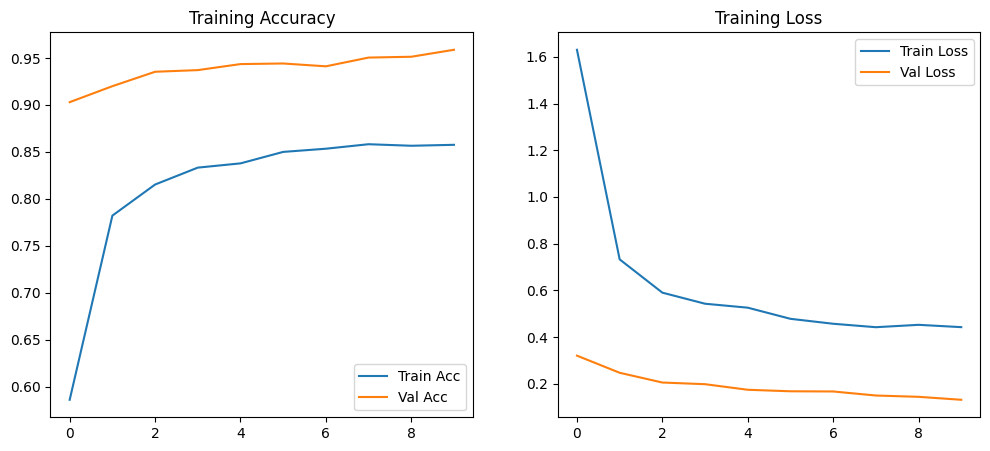

In [7]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Training Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Training Loss")
plt.show()


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 153s 524ms/step - accuracy: 0.6720 - loss: 1.1604 - val_accuracy: 0.9534 - val_loss: 0.1350
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 112s 450ms/step - accuracy: 0.7692 - loss: 0.8120 - val_accuracy: 0.9522 - val_loss: 0.1399
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 113s 455ms/step - accuracy: 0.7914 - loss: 0.6900 - val_accuracy: 0.9510 - val_loss: 0.1436
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 114s 457ms/step - accuracy: 0.8112 - loss: 0.6166 - val_accuracy: 0.9538 - val_loss: 0.1390
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 115s 461ms/step - accuracy: 0.8178 - loss: 0.5644 - val_accuracy: 0.9563 - val_loss: 0.1346
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 112s 448ms/step - accuracy: 0.8465 - loss: 0.5031 - val_accuracy: 0.9583 - val_loss: 0.1317
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 112s 451ms/step - accuracy: 0.8436 - loss: 0.5027 - val_accuracy: 0.9587 - val_loss: 0.1291
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 112s 450ms/step - accuracy: 0.8448 -

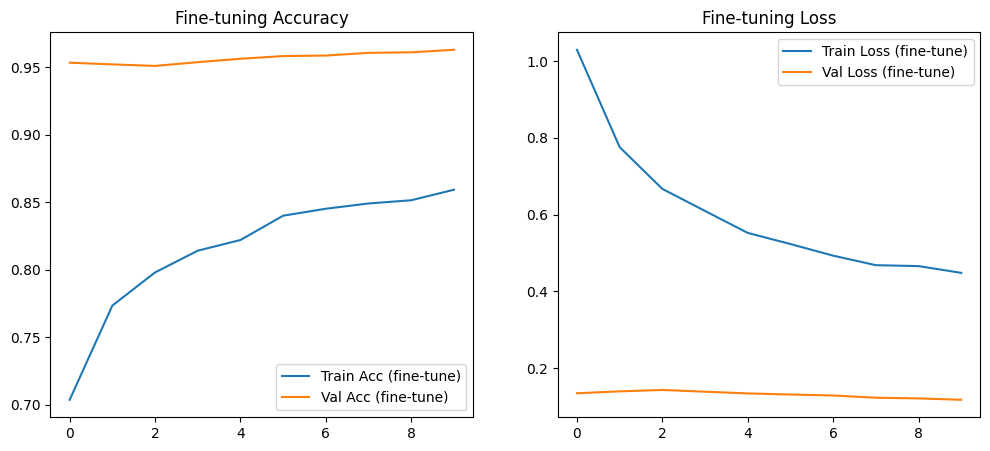

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="categorical_crossentropy", metrics=["accuracy"])

fine_tune_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

# Plot fine-tuning history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fine_tune_history.history["accuracy"], label="Train Acc (fine-tune)")
plt.plot(fine_tune_history.history["val_accuracy"], label="Val Acc (fine-tune)")
plt.legend(); plt.title("Fine-tuning Accuracy")
plt.subplot(1,2,2)
plt.plot(fine_tune_history.history["loss"], label="Train Loss (fine-tune)")
plt.plot(fine_tune_history.history["val_loss"], label="Val Loss (fine-tune)")
plt.legend(); plt.title("Fine-tuning Loss")
plt.show()


Upload a dog image to predict its breed:


Saving images.webp to images (3).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

Predicted dog breed: Golden Retriever (99.90% confidence)

Top 3 predictions:
Golden Retriever: 99.90%
Labrador: 0.09%
Cocker: 0.01%


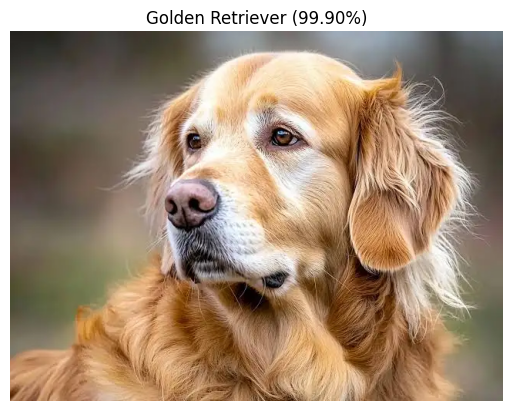

In [9]:
class_indices = train_generator.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}

def preprocess_image(image_path):
    img = PILImage.open(image_path).convert("RGB")
    img = img.resize((img_width, img_height))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

def predict_breed():
    print("Upload a dog image to predict its breed:")
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_input = preprocess_image(filename)
        preds = model.predict(img_input)

        pred_idx = np.argmax(preds, axis=1)[0]
        breed_name = idx_to_class[pred_idx]
        confidence = preds[0][pred_idx]*100

        print(f"\nPredicted dog breed: {breed_name} ({confidence:.2f}% confidence)")

        # Top 3 predictions
        top3_idx = preds[0].argsort()[-3:][::-1]
        print("\nTop 3 predictions:")
        for i in top3_idx:
            print(f"{idx_to_class[i]}: {preds[0][i]*100:.2f}%")

        # Show image
        plt.imshow(PILImage.open(filename))
        plt.axis("off")
        plt.title(f"{breed_name} ({confidence:.2f}%)")
        plt.show()


predict_breed()
